## Breast Cancer Prediction

In [38]:
# Import necessary packages
import os , glob
from imutils import paths
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import random
import subprocess, sys

import skimage
from skimage.io import imread , imread_collection 

from sklearn.metrics import accuracy_score , classification_report
from sklearn.preprocessing import LabelEncoder,StandardScaler

import keras
from keras.applications import mobilenet
from keras.layers import Dense ,Dropout
from keras.models import Sequential

In [2]:
# Get some high level stats from the images
images_path ='../Data/Images/*/'
patient_list = list(glob.glob(images_path))
print(f'Number of the patient :{len(patient_list)}')

images_count = 0
for i in range(0 , len(patient_list)):
    images_count+=len(glob.glob(patient_list[i]+'/*/*'))
print(f'Number of the images :{images_count}')

benign_count = 0
for i in range(0 , len(patient_list)):
    benign_count+=len(glob.glob(patient_list[i]+'/0/*'))
print(f'Number of the benign (non-cancerous) cells :{benign_count}')

malignant_count = 0
for i in range(0 , len(patient_list)):
    malignant_count+=len(glob.glob(patient_list[i]+'/1/*'))
print(f'Number of the malignant (cancerous) cells :{malignant_count}')

Number of the patient :279
Number of the images :277524
Number of the benign (non-cancerous) cells :198738
Number of the malignant (cancerous) cells :78786


In [20]:
# Build the Dataframe with counts
BC_list = [["0", benign_count], ["1", malignant_count]]
BC_df = pd.DataFrame(BC_list, columns=['Diagnosis', 'Count'])
BC_df.head()

,Diagnosis,Count
0,0,198738
1,1,78786


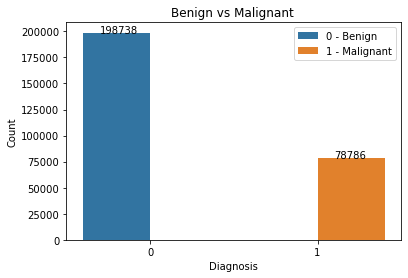


The difference between benign(0) and malignant(1) : 119952


In [31]:
# Plot the bar chart
ax = sns.barplot(x="Diagnosis", y="Count", data=BC_df, hue="Diagnosis")
plt.title('Benign vs Malignant ')
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+10))
    
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['0 - Benign', '1 - Malignant'], loc='best')
plt.show()
print(f'\nThe difference between benign(0) and malignant(1) : {(benign_count-malignant_count)}')

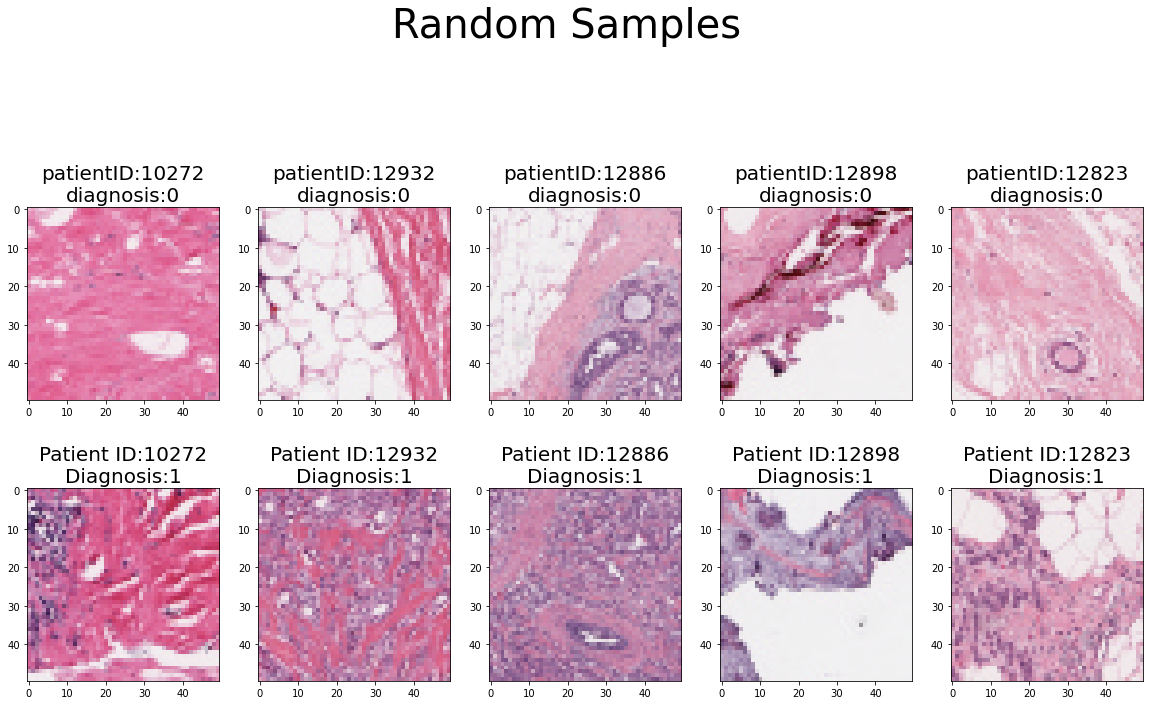

In [37]:
# Plot random cell samples

# Create list of patient objects
test=[glob.glob(patient_list[i]+'/*/*') for i in range(0,len(patient_list))]
fig,axes = plt.subplots(figsize=(20,25))
  
# Get the random sample prepared for 5 patients
ran_sample = [random.choice(test)for x in range(0,5)]

# Loop through and plot first (to get benign(0)) and last (to get mailgnant(1)) images.
for i in range(0,len(ran_sample)):
    # Plot first image
    path=ran_sample[i][0]
    img = imread(path)
    axes =plt.subplot(5,5,i+1)
    plt.imshow(img)
    axes.set_title('patientID:'+str(path.split('/')[3])+'\n'
                   +'diagnosis:'+str(path.split('/')[4]),fontsize=20)
    # Plot last image
    path=ran_sample[i][len(ran_sample[i])-1]
    img = imread(path)
    axes =plt.subplot(5,5,i+6)
    plt.imshow(img)
    axes.set_title('Patient ID:'+str(path.split('/')[3])+'\n'
                   +'Diagnosis:'+str(path.split('/')[4]),fontsize=20)

fig.suptitle('Random Samples',fontsize=40)
plt.show() 

## Modeling

In [32]:
# Set generic vairbales
# Set parameters for splitting the input data
images_path ='../Data/Images-Model'
BASE_PATH = "../Data"
TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])
VAL_PATH = os.path.sep.join([BASE_PATH, "validation"])
TEST_PATH = os.path.sep.join([BASE_PATH, "testing"])
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2

In [39]:
# Below section copies the images from source to the respective directories for preparing
# testing, training, and validation datasets.

# Below method copies images using OS command
def copyWithSubprocess(source, dest):  
    # Use below cmd for windows
    # cmd=['xcopy', source, dest, '/K/O/X']
    cmd=['cp', source, dest]
    proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    proc.stdout.close()
    proc.stderr.close()
    
    
# Split the data now
originalPaths=list(paths.list_images(images_path))
random.seed(7)
random.shuffle(originalPaths)
index=int(len(originalPaths)*TRAIN_SPLIT)
trainPaths=originalPaths[:index]
testPaths=originalPaths[index:]

index=int(len(trainPaths)*VAL_SPLIT)
valPaths=trainPaths[:index]
trainPaths=trainPaths[index:]
datasets=[("training", trainPaths, TRAIN_PATH),
          ("validation", valPaths, VAL_PATH),
          ("testing", testPaths, TEST_PATH)
]
for (setType, originalPaths, basePath) in datasets:    
    print(f'Building {setType} set')
    if not os.path.exists(basePath):
        print(f'Building directory {basePath}')
        os.makedirs(basePath)
    for path in originalPaths:
        file=path.split(os.path.sep)[-1]
        label=file[-5:-4]
        labelPath=os.path.sep.join([basePath,label])        
        if not os.path.exists(labelPath):
            print(f'Building directory {labelPath}')
            os.makedirs(labelPath)
        newPath=os.path.sep.join([labelPath, file])
        #shutil.copy2(path, newPath)
        copyWithSubprocess(path,newPath)

Building training set
Building directory ../Data/training
Building directory ../Data/training/0
Building directory ../Data/training/1
Building validation set
Building directory ../Data/validation
Building directory ../Data/validation/0
Building directory ../Data/validation/1
Building testing set
Building directory ../Data/testing
Building directory ../Data/testing/1
Building directory ../Data/testing/0


In [40]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

height=48
width=48
depth=3
classes=2

# Build model
model=Sequential()
shape=(height,width,depth)
channelDim=-1
if K.image_data_format()=="channels_first":
    shape=(depth,height,width)
    channelDim=1      
model.add(SeparableConv2D(32, (3,3), padding="same",input_shape=shape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channelDim))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(SeparableConv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channelDim))
model.add(SeparableConv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channelDim))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(SeparableConv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channelDim))
model.add(SeparableConv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channelDim))
model.add(SeparableConv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channelDim))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(classes))
model.add(Activation("softmax"))

Instructions for updating:
Colocations handled automatically by placer.


In [51]:
# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 48, 48, 32)        155       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 24, 24, 64)        2400      
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 64)       

In [41]:
# Get the data ready for modeling
import matplotlib
#matplotlib.use("Agg")
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adagrad
from keras.utils import np_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

NUM_EPOCHS=20
INIT_LR=1e-2
BS=32

trainPaths=list(paths.list_images(TRAIN_PATH))
lenTrain=len(trainPaths)
lenVal=len(list(paths.list_images(VAL_PATH)))
lenTest=len(list(paths.list_images(TEST_PATH)))

trainLabels=[int(p.split(os.path.sep)[-2]) for p in trainPaths]
trainLabels=np_utils.to_categorical(trainLabels)
classTotals=trainLabels.sum(axis=0)
classWeight=classTotals.max()/classTotals

trainAug = ImageDataGenerator(
  rescale=1/255.0,
  rotation_range=20,
  zoom_range=0.05,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.05,
  horizontal_flip=True,
  vertical_flip=True,
  fill_mode="nearest")
valAug=ImageDataGenerator(rescale=1 / 255.0)
trainGen = trainAug.flow_from_directory(
  TRAIN_PATH,
  class_mode="categorical",
  target_size=(48,48),
  color_mode="rgb",
  shuffle=True,
  batch_size=BS)
valGen = valAug.flow_from_directory(
  VAL_PATH,
  class_mode="categorical",
  target_size=(48,48),
  color_mode="rgb",
  shuffle=False,
  batch_size=BS)
testGen = valAug.flow_from_directory(
  TEST_PATH,
  class_mode="categorical",
  target_size=(48,48),
  color_mode="rgb",
  shuffle=False,
  batch_size=BS)

Found 32106 images belonging to 2 classes.
Found 8026 images belonging to 2 classes.
Found 10034 images belonging to 2 classes.


In [42]:
# Train the model
opt=Adagrad(lr=INIT_LR,decay=INIT_LR/NUM_EPOCHS)
model.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])

M=model.fit_generator(
  trainGen,
  steps_per_epoch=lenTrain//BS,
  validation_data=valGen,
  validation_steps=lenVal//BS,
  class_weight=classWeight,
  epochs=NUM_EPOCHS)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
1003/1003 [==============================] - 653s 651ms/step - loss: 0.3840 - accuracy: 0.8443 - val_loss: 2.4475 - val_accuracy: 0.8580
Epoch 2/20
1003/1003 [==============================] - 385s 384ms/step - loss: 0.3240 - accuracy: 0.8653 - val_loss: 0.4469 - val_accuracy: 0.8682
Epoch 3/20
1003/1003 [==============================] - 346s 345ms/step - loss: 0.3072 - accuracy: 0.8708 - val_loss: 1.1875 - val_accuracy: 0.8682
Epoch 4/20
1003/1003 [==============================] - 320s 319ms/step - loss: 0.3017 - accuracy: 0.8725 - val_loss: 0.4981 - val_accuracy: 0.8712
Epoch 5/20
1003/1003 [==============================] - 325s 324ms/step - loss: 0.2989 - accuracy: 0.8748 - val_loss: 1.7734 - val_accuracy: 0.8636
Epoch 6/20
1003/1003 [==============================] - 321s 320ms/step - loss: 0.2995 - accuracy: 0.8752 - val_loss: 1.5213 - val_accuracy: 0.8743
Epoch 7/20
1003/1003 [==============================] - 314s 313

In [48]:
# Save the trained model
model.save('CancerNet')

# Use below to reload model
#model=keras.models.load_model("CancerNet")

import pickle
# Store off the history for later
with open('trainHistoryDict', 'wb') as file_pi:
        pickle.dump(M.history, file_pi)
        
# Use below to read
#history = pickle.load(open('/trainHistoryDict'), "rb")

In [44]:
# Additional training if needed

#model2=model
#NUM_EPOCHS=30
#M3=model2.fit_generator(
#  trainGen,
#  steps_per_epoch=lenTrain//BS,
#  validation_data=valGen,
#  validation_steps=lenVal//BS,
#  class_weight=classWeight,
#  epochs=NUM_EPOCHS)

#model2.save('./CancerNet21-50')
#with open('trainHistoryDict_21-50', 'wb') as file_pi:
#        pickle.dump(M3.history, file_pi)

In [45]:
# Combine histories if model was trained multiple times.
def appendHist(h1, h2):
    if h1 == {}:
        return h2
    else:
        dest = {}
        for key, value in h1.items():
            dest[key] = value + h2[key]
        return dest
    
#history = appendHist(M.history, M3.history)

history=M.history
print(len(history["accuracy"]))

20


In [46]:
# Let's test the model and see how it performed
testGen.reset()
pred_indices=model.predict_generator(testGen,steps=(lenTest//BS)+1)
pred_indices=np.argmax(pred_indices,axis=1)

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      7721
           1       0.73      0.74      0.74      2313

    accuracy                           0.88     10034
   macro avg       0.83      0.83      0.83     10034
weighted avg       0.88      0.88      0.88     10034



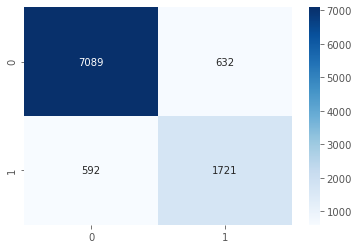

0.8780147498505083
0.7314067148321292
0.7440553393860787
0.7376768109729961
[[7089  632]
 [ 592 1721]]
Accuracy: 0.8780147498505083
Specificity: 0.7440553393860787
Sensitivity: 0.9181453179639943


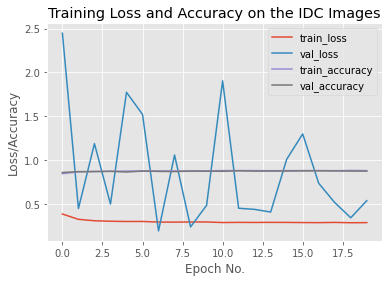

In [49]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
import seaborn as sns

print(classification_report(testGen.classes, pred_indices, target_names=testGen.class_indices.keys()))
cm=confusion_matrix(testGen.classes,pred_indices)
plt.figure()
sns.heatmap(cm, annot=True,fmt='.0f', cmap="Blues")
plt.show()
#plt.savefig('3_Confusion_Matrix.png')
#score = model.evaluate(X_test, y_test)
#print(score)
print(accuracy_score(testGen.classes, pred_indices))
print(precision_score(testGen.classes, pred_indices))
print(recall_score(testGen.classes, pred_indices))
print(f1_score(testGen.classes, pred_indices))
total=sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
specificity=cm[1,1]/(cm[1,0]+cm[1,1])
sensitivity=cm[0,0]/(cm[0,0]+cm[0,1])
print(cm)
print(f'Accuracy: {accuracy}')
print(f'Specificity: {specificity}')
print(f'Sensitivity: {sensitivity}')
#N = NUM_EPOCHS
N = len(history["accuracy"])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N), history["loss"], label="train_loss")
plt.plot(np.arange(0,N), history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0,N), history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy on the IDC Images")
plt.xlabel("Epoch No.")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.show()
#plt.savefig('3_plot.png')

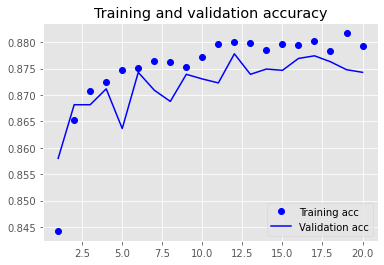

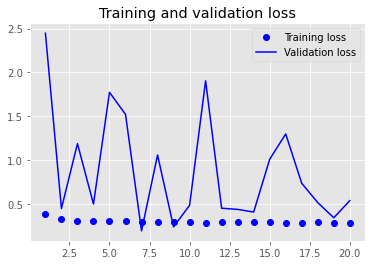

In [50]:
# Plot the model performance over time
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)
plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
#plt.savefig('3_plot_acc.png')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
#plt.savefig('3_plot_loss.png')